In [232]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d

In [233]:
N_skin = 400
N_bandage = 400
control_trajectory = np.array([[-0.4677,  0.0367,  0.1300],
                               [-0.4,  0.0367,  0.2300],
                               [-0.3,  0.0367,  0.33],
                               [-0.2,  0.0367,  0.43],
                               [-0.0,  0.0367,  0.53],
                               [0.2,  0.0367,  0.63],
                               [0.4,  0.0367,  0.73],
                               [0.6,  0.0367,  0.83]])
control_trajectory[:, 2] += 0.24

In [234]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10 * control_trajectory.shape[0])  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)

In [235]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=1, y_length=0.8, z_length=0.24), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.24), x_length=1, y_length=0.8, z_length=0.24), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
# softbody.init_rigid_constraints(1, 0.3)
# softbody.init_shape_constraints_thinshell([1])
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 306)
softbody.add_multi_boundary_constrain(1, 0, 0.1, range(198, 296))

detect 2 object


In [236]:
softbody.V[400 + 306]

tensor([-0.4173, -0.0577,  0.3600])

In [237]:
# color = np.zeros(400)
# color[306] = 1

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


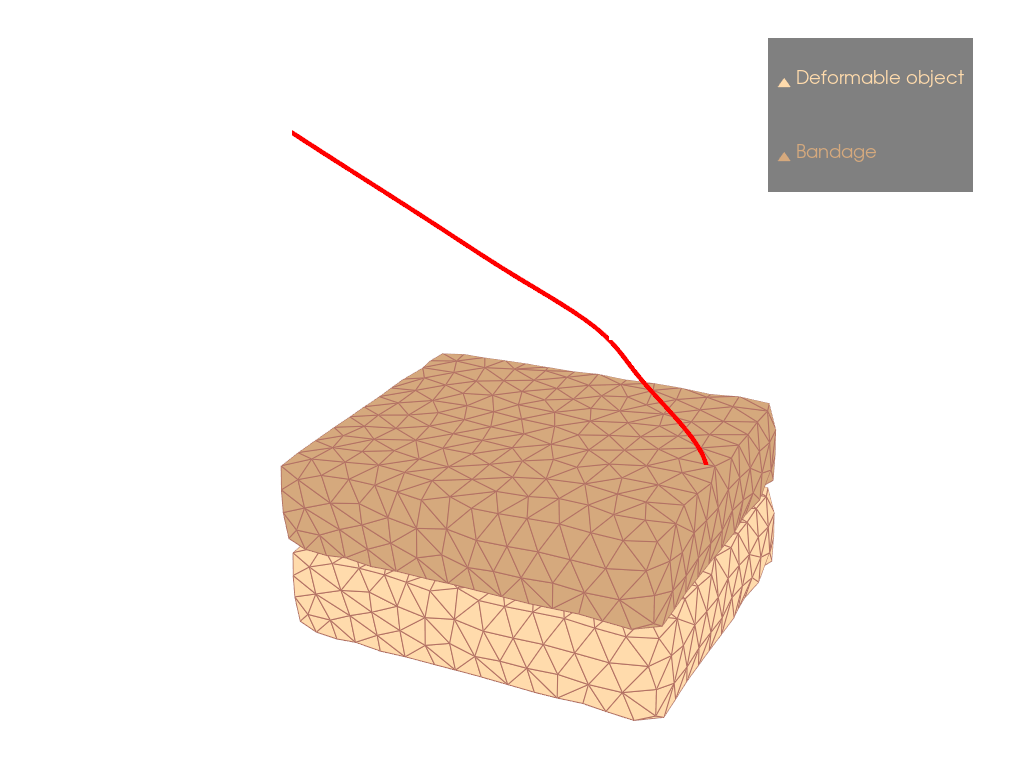

In [238]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_lines(control_trajectory.cpu().numpy(), connected=True, color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(-1.5456585149189535, 2.774608471223274, 1.869515302491473),
 (0.04999999999999999, 8.326672684688674e-17, 0.4750000013411045),
 (0.1445792296290427, -0.37671903820836455, 0.9149751978120703)]
pl.show()

In [239]:
# softbody.fix_point(1, 1)

In [240]:
cloth_dist_stiffness = 1e3
V_boundary_stiffness = 1e3
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3

In [241]:
V_boundary_stiffness.shape

torch.Size([522, 1])

In [242]:
pl.open_gif('tissue2tissue.gif')
for i in range(control_trajectory.shape[0]):
    softbody.V[softbody.offset_list[1] + 306] = control_trajectory[i]
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
    V_boundary_stiffness[energy.squeeze() > 0.5] = 1e-8
    # print(energy)
    skin_mesh.points = softbody.V[:N_skin].cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].cpu().numpy()
    # pl.remove_actor(bandage_actor)
    # bandage_actor = pl.add_points(softbody.V[N_skin:N_skin+N_bandage].cpu().numpy(), color='r')
    pl.write_frame()
pl.close()